In [17]:
'''
Here we have code to plot perturbagen pred and response pred performance results for chemical datasets
Random splitting
'''
##Here we have code to replicate figures included in Figure 3 of main paper
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os.path as osp
from glob import glob
import sys
sys.path.append('../../')
from constants import *
import os
import numpy as np
from scipy import stats


outdir = 'processed/'
os.makedirs(outdir, exist_ok = True)

# Chemical datasets

## Perturbagen prediction

In [18]:
base_path = '../../../results_metrics_aggregated_bme/GRN/perturbagen_pred/v2/chemical/within'
performance = {}
##GRN perf
paths = glob(osp.join(base_path, '*_drugpred_within_best.csv'))

for path in paths:
    df = pd.read_csv(path)
    df = df[df['Set'] == 'Test']
    
    # Process the new DataFrame to update the dictionary
    method_name = 'GRN'

    # Populate the dictionary
    for index, row in df.iterrows():
        cell_line = row['Cellline']
        metric = row['Metric']
        if metric == 'ranking score':
            metric = 'rankings'
        if metric == 'ranking score DCG':
            metric = 'nDCG'
        
        
        if cell_line not in performance:
            performance[cell_line] = {}
            
        if metric not in performance[cell_line]:
            performance[cell_line][metric] = {method_name: []}
        
        values = [row['Fold 1'], row['Fold 2'], row['Fold 3'], row['Fold 4'], row['Fold 5']]
        performance[cell_line][metric][method_name] = values


In [19]:
#PPI - chemical, randon (within)
base_path = '../../../results_metrics_aggregated_bme/perturbagen_pred'
paths = glob(osp.join(base_path, 'v2/PDGrapher/chemical/random/*_drugpred_within_best.csv'))

for path in paths:
    df = pd.read_csv(path)
    df = df[df['Set'] == 'Test']
    
    # Process the new DataFrame to update the dictionary
    method_name = 'PPI'

    # Populate the dictionary
    for index, row in df.iterrows():
        cell_line = row['Cellline']
        metric = row['Metric']
        if metric == 'ranking score':
            metric = 'rankings'
        if metric == 'ranking score - DCG':
            metric = 'nDCG'       
        
        if cell_line not in performance:
            performance[cell_line] = {}
            
        if metric not in performance[cell_line]:
            performance[cell_line][metric] = {method_name: []}
        
        values = [row['Fold 1'], row['Fold 2'], row['Fold 3'], row['Fold 4'], row['Fold 5']]
        performance[cell_line][metric][method_name] = values

In [20]:
cell_line_to_cancer_type = {
    'A549': 'Lung-A549',
    'A375': 'Skin-A375',
    'BT20': 'Breast-BT20',
    'HELA': 'Cervix-HELA',
    'HT29': 'Colon-HT29',
    'MCF7': 'Breast-MCF7',
    'MDAMB231': 'Breast-MDAMB231',
    'PC3': 'Prostate-PC3',
    'VCAP': 'Prostate-VCAP'
}

### Panel proportion of accurate samples

/tmp/ipykernel_1964615/2779713506.py:60: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)


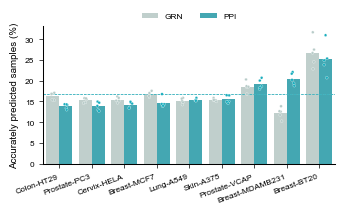

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import font_manager
font_dirs = ['/home/gonzag46/.fonts']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42  # Output Type 42 (TrueType), editable in Illustrator

# Extract the data for 'rankings' into a DataFrame
metric = 'percentage of samples with partially accurate predictions'
data = []
for cellline, metrics in performance.items():
    if metric in metrics:
        for method, values in metrics[metric].items():
            for value in values:
                data.append([cellline, method, value])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Cell Line', 'Method', metric])

# Calculate the mean 'rankings' for each cell line and method
df_mean = df.groupby(['Cell Line', 'Method']).mean().reset_index()


#Rename cell lines
df['Cancer Type'] = df['Cell Line'].map(cell_line_to_cancer_type)
df_mean['Cancer Type'] = df_mean['Cell Line'].map(cell_line_to_cancer_type)
# Replace x-axis labels with cancer types
df['Cell Line'] = df['Cancer Type']
df_mean['Cell Line'] = df_mean['Cancer Type']



# Order cell lines based on values for PDGrapher
pdgrapher_means = df_mean[df_mean['Method'] == 'PPI'].sort_values(by=metric)
ordered_cell_lines = pdgrapher_means['Cell Line']

# Reorder the DataFrame based on ordered cell lines
df['Cell Line'] = pd.Categorical(df['Cell Line'], categories=ordered_cell_lines, ordered=True)
df_mean['Cell Line'] = pd.Categorical(df_mean['Cell Line'], categories=ordered_cell_lines, ordered=True)

# Define a color palette that matches the existing figures
palette = {
    'GRN': '#B8CCC9',
    'PPI': '#1AAEBE',
}

# Define the order of methods
method_order = ['GRN', 'PPI']

with sns.plotting_context(plotting_context):
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(3.543, 2.19))

    # Create a bar plot for each method
    sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)

    # Overlay individual data points
    sns.stripplot(data=df, x='Cell Line', y=metric, hue='Method', palette=palette, dodge=True, jitter=True, alpha=1.0, hue_order=method_order, size=2, edgecolor="white", linewidth=0.2)





    # Add horizontal lines for the overall mean ranking for each method
    for method in method_order:
        overall_mean = df[df['Method'] == method][metric].mean()
        plt.axhline(y=overall_mean, linestyle='--', color=palette[method], linewidth=0.5)

    # Remove title
    plt.title('')
    plt.ylim

    # Remove X-axis label
    plt.xlabel('')
    sns.despine()

    # Adjust legend to only include the bars and place it at the top
    handles, labels = plt.gca().get_legend_handles_labels()
    bar_handles = handles[:len(method_order)]
    bar_labels = labels[:len(method_order)]
    plt.legend(bar_handles, bar_labels, bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=4, frameon=False, title=None)
    plt.xticks(rotation=20, ha="right")
    plt.subplots_adjust(bottom = 0.25, right = 0.95)
    plt.ylabel('Accurately predicted samples (%)')
    plt.savefig(osp.join(outdir, 'panel_partially_accurate_pred.pdf'))
    plt.show()




## Panel nDCG

/tmp/ipykernel_1964615/3596126777.py:54: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)


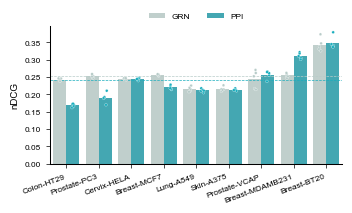

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# Extract the data for 'rankings' into a DataFrame
metric = 'nDCG'
data = []
for cellline, metrics in performance.items():
    if metric in metrics:
        for method, values in metrics[metric].items():
            for value in values:
                data.append([cellline, method, value])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Cell Line', 'Method', metric])

# Calculate the mean 'rankings' for each cell line and method
df_mean = df.groupby(['Cell Line', 'Method']).mean().reset_index()


#Rename cell lines
df['Cancer Type'] = df['Cell Line'].map(cell_line_to_cancer_type)
df_mean['Cancer Type'] = df_mean['Cell Line'].map(cell_line_to_cancer_type)
# Replace x-axis labels with cancer types
df['Cell Line'] = df['Cancer Type']
df_mean['Cell Line'] = df_mean['Cancer Type']



# Order cell lines based on values for PDGrapher
pdgrapher_means = df_mean[df_mean['Method'] == 'PPI'].sort_values(by=metric)
# ordered_cell_lines = pdgrapher_means['Cell Line']

# Reorder the DataFrame based on ordered cell lines
df['Cell Line'] = pd.Categorical(df['Cell Line'], categories=ordered_cell_lines, ordered=True)
df_mean['Cell Line'] = pd.Categorical(df_mean['Cell Line'], categories=ordered_cell_lines, ordered=True)

# Define a color palette that matches the existing figures
palette = {
    'GRN': '#B8CCC9',
    'PPI': '#1AAEBE',
}

# Define the order of methods
method_order = ['GRN', 'PPI']

with sns.plotting_context(plotting_context):
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(3.543, 2.19))

    # Create a bar plot for each method
    sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)

    # Overlay individual data points
    sns.stripplot(data=df, x='Cell Line', y=metric, hue='Method', palette=palette, dodge=True, jitter=True, alpha=1.0, hue_order=method_order, size=2, edgecolor="white", linewidth=0.2)





    # Add horizontal lines for the overall mean ranking for each method
    for method in method_order:
        overall_mean = df[df['Method'] == method][metric].mean()
        plt.axhline(y=overall_mean, linestyle='--', color=palette[method], linewidth=0.5)

    # Remove title
    plt.title('')
    plt.ylim

    # Remove X-axis label
    plt.xlabel('')
    sns.despine()

    # Adjust legend to only include the bars and place it at the top
    handles, labels = plt.gca().get_legend_handles_labels()
    bar_handles = handles[:len(method_order)]
    bar_labels = labels[:len(method_order)]
    plt.legend(bar_handles, bar_labels, bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=4, frameon=False, title=None)
    plt.xticks(rotation=20, ha="right")
    plt.subplots_adjust(bottom = 0.25, right = 0.95)
    plt.ylabel('nDCG')
    plt.savefig(osp.join(outdir, 'panel_ndcg.pdf'))
    plt.show()




### Aggregated recall@k

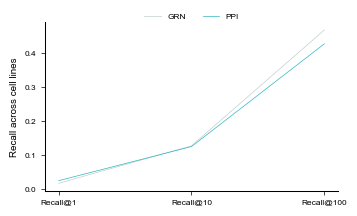

In [23]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize an empty list to store the data
data = []

# Iterate over the performance dictionary to extract all recall metrics
for cellline, metrics in performance.items():
    for metric in ['recall@1', 'recall@10', 'recall@100']:
        if metric in metrics:
            for method, values in metrics[metric].items():
                for value in values:
                    data.append([cellline, metric, method, value])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Cell Line', 'Metric', 'Method', 'Value'])

# Convert the 'Value' column to numeric to avoid any conversion issues
df['Value'] = pd.to_numeric(df['Value'], errors='coerce')

# Calculate the mean for each method and metric across all cell lines
df_mean = df.groupby(['Metric', 'Method'])['Value'].mean().reset_index()



#Color palette
palette = {
    'GRN': '#B8CCC9',
    'PPI': '#1AAEBE',
}
# Define the order of methods
method_order = ['GRN', 'PPI']
df_mean['Metric'] = [e.capitalize() for e in df_mean['Metric']]

with sns.plotting_context(plotting_context):
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(3.543, 2.19))

    # Create a line plot for each method showing the mean across all cell lines
    sns.lineplot(data=df_mean, x='Metric', y='Value', hue='Method', palette=palette, hue_order=method_order, markers=True, dashes=False, alpha=0.9)

    # Remove X-axis label
    plt.xlabel('')

    sns.despine()

    # Adjust legend to place it at the top
    handles, labels = plt.gca().get_legend_handles_labels()
    line_handles =  handles[:len(method_order)]
    line_labels = labels[:len(method_order)]
    plt.legend(line_handles, line_labels, bbox_to_anchor=(0.5, 1.1), loc='upper center', ncol=4, frameon=False, title=None)
    # plt.subplots_adjust(top=0.9)
    plt.subplots_adjust(right = 0.95)
    # plt.xticks(rotation=20, ha="right")
    plt.ylabel('Recall across cell lines')
    plt.savefig(osp.join(outdir, 'panel_aggregated_mean_recall_metrics.pdf'))
    plt.show()


## Response prediction

In [24]:
#Ablation
paths = glob(osp.join('../../../results_metrics_aggregated_bme/GRN/response_pred/within/chemical/pdgrapher_chemical_r2_*_topk.csv'))


performance = {}
for path in paths:
    df = pd.read_csv(path)
    cellline = df['cellline1'].iloc[0]
    # Process the new DataFrame to update the dictionary
    
    method_name = 'GRN'

    for topk in [10, 20, 40, 80]:
        dfi = df[df['topk'] == topk]
        metric_data = {
            'R2 - (top {})'.format(topk): dfi.groupby('split')['r2'].mean().reset_index()['r2'].tolist(),

        }
    
        # Initialize nested dictionaries if not already present
        if cellline not in performance:
            performance[cellline] = {}
        
        for metric, value in metric_data.items():
            if metric not in performance[cellline]:
                performance[cellline][metric] = {}
            if method_name not in performance[cellline][metric]:
                performance[cellline][metric][method_name] = []
            performance[cellline][metric][method_name] += value
            

#Base
paths = glob(osp.join('../../../results_metrics_aggregated_bme/response_pred_pcc/PDGrapher/within/pdgrapher_chemical_r2_*_topk.csv'))


for path in paths:
    df = pd.read_csv(path)
    cellline = df['cellline1'].iloc[0]
    # Process the new DataFrame to update the dictionary
    

    method_name = 'PPI'


    for topk in [10, 20, 40, 80]:
        dfi = df[df['topk'] == topk]
        metric_data = {
            'R2 - (top {})'.format(topk): dfi.groupby('split')['r2'].mean().reset_index()['r2'].tolist(),

        }
    
        # Initialize nested dictionaries if not already present
        if cellline not in performance:
            performance[cellline] = {}
        
        for metric, value in metric_data.items():
            if metric not in performance[cellline]:
                performance[cellline][metric] = {}
            if method_name not in performance[cellline][metric]:
                performance[cellline][metric][method_name] = []
            performance[cellline][metric][method_name] += value

In [25]:
if 'HA1E' in performance:
    del performance['HA1E']

/tmp/ipykernel_1964615/668033073.py:54: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)


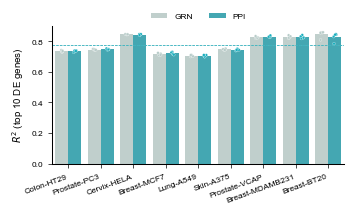

/tmp/ipykernel_1964615/668033073.py:54: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)


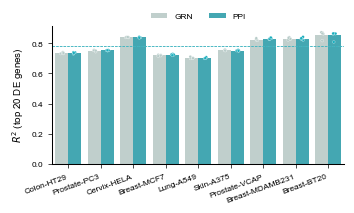

/tmp/ipykernel_1964615/668033073.py:54: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)


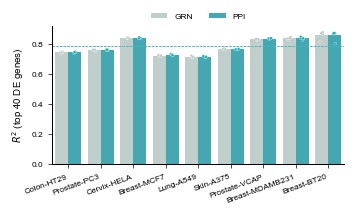

/tmp/ipykernel_1964615/668033073.py:54: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)


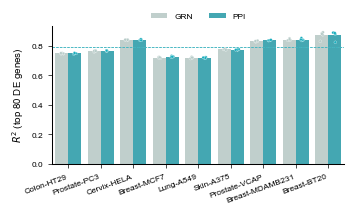

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


ytitles = {'R2 - (top 10)': ' (top 10 DE genes)', 'R2 - (top 20)': ' (top 20 DE genes)', 'R2 - (top 40)': ' (top 40 DE genes)', 'R2 - (top 80)': ' (top 80 DE genes)'}

# Extract the data for 'rankings' into a DataFrame
for metric in ['R2 - (top 10)', 'R2 - (top 20)', 'R2 - (top 40)', 'R2 - (top 80)']:

    data = []
    for cellline, metrics in performance.items():
        if metric in metrics:
            for method, values in metrics[metric].items():
                for value in values:
                    data.append([cellline, method, value])

    # Create a DataFrame
    df = pd.DataFrame(data, columns=['Cell Line', 'Method', metric])

    # Calculate the mean 'rankings' for each cell line and method
    df_mean = df.groupby(['Cell Line', 'Method']).mean().reset_index()

    #Rename cell lines
    df['Cancer Type'] = df['Cell Line'].map(cell_line_to_cancer_type)
    df_mean['Cancer Type'] = df_mean['Cell Line'].map(cell_line_to_cancer_type)
    # Replace x-axis labels with cancer types
    df['Cell Line'] = df['Cancer Type']
    df_mean['Cell Line'] = df_mean['Cancer Type']



    # Order cell lines based on values for PDGrapher
    pdgrapher_means = df_mean[df_mean['Method'] == 'PPI'].sort_values(by=metric)
    # ordered_cell_lines = pdgrapher_means['Cell Line']

    # Reorder the DataFrame based on ordered cell lines
    df['Cell Line'] = pd.Categorical(df['Cell Line'], categories=ordered_cell_lines, ordered=True)
    df_mean['Cell Line'] = pd.Categorical(df_mean['Cell Line'], categories=ordered_cell_lines, ordered=True)

    # Define a color palette that matches the existing figures
    palette = {
        'GRN': '#B8CCC9',
        'PPI': '#1AAEBE',
    }
    # Define the order of methods
    method_order = ['GRN', 'PPI']

    with sns.plotting_context(plotting_context):
        # Initialize the plot
        fig, ax = plt.subplots(figsize=(3.543, 2.19))

        # Create a bar plot for each method
        sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)

        # Overlay individual data points
        sns.stripplot(data=df, x='Cell Line', y=metric, hue='Method', palette=palette, dodge=True, jitter=True, alpha=1.0, hue_order=method_order, size=2, edgecolor="white", linewidth=0.2)





        # Add horizontal lines for the overall mean ranking for each method
        for method in method_order:
            overall_mean = df[df['Method'] == method][metric].mean()
            plt.axhline(y=overall_mean, linestyle='--', color=palette[method], linewidth=0.5)

        # Remove title
        plt.title('')
        plt.ylim

        # Remove X-axis label
        plt.xlabel('')
        sns.despine()

        # Adjust legend to only include the bars and place it at the top
        handles, labels = plt.gca().get_legend_handles_labels()
        bar_handles = handles[:len(method_order)]
        bar_labels = labels[:len(method_order)]
        plt.legend(bar_handles, bar_labels, bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=4, frameon=False, title=None)
        plt.xticks(rotation=20, ha="right")
        plt.subplots_adjust(bottom = 0.25, right = 0.95)
        plt.ylabel(r'$R^2$' + ytitles[metric])
        plt.savefig(osp.join(outdir, 'panel_{}.pdf'.format(metric)))
        plt.show()


